In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FREDAPI_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error,r2_score


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)



cuda


In [2]:


df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .77)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [3]:

class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=512, num_layers=1, output_size=1):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
bidirectional_lstm = BiLSTM()
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [5]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')
        

/tmp/ipykernel_5129/1334293925.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_5129/1334293925.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.4658; Test RMSE: 0.1872
Epoch: 1; train_RMSE: 0.419; Test RMSE: 0.1455
Epoch: 2; train_RMSE: 0.3694; Test RMSE: 0.1061
Epoch: 3; train_RMSE: 0.3154; Test RMSE: 0.0806
Epoch: 4; train_RMSE: 0.257; Test RMSE: 0.09787
Epoch: 5; train_RMSE: 0.2002; Test RMSE: 0.1598
Epoch: 6; train_RMSE: 0.1716; Test RMSE: 0.2492
Epoch: 7; train_RMSE: 0.2061; Test RMSE: 0.3468
Epoch: 8; train_RMSE: 0.2441; Test RMSE: 0.3984
Epoch: 9; train_RMSE: 0.24; Test RMSE: 0.3923
Epoch: 10; train_RMSE: 0.2111; Test RMSE: 0.3533
Epoch: 11; train_RMSE: 0.1807; Test RMSE: 0.3021
Epoch: 12; train_RMSE: 0.1643; Test RMSE: 0.2519
Epoch: 13; train_RMSE: 0.1641; Test RMSE: 0.2095
Epoch: 14; train_RMSE: 0.1725; Test RMSE: 0.1776
Epoch: 15; train_RMSE: 0.1815; Test RMSE: 0.1559
Epoch: 16; train_RMSE: 0.1869; Test RMSE: 0.1434
Epoch: 17; train_RMSE: 0.1874; Test RMSE: 0.1384
Epoch: 18; train_RMSE: 0.1832; Test RMSE: 0.1398
Epoch: 19; train_RMSE: 0.1751; Test RMSE: 0.1467
Epoch: 20; train_RMSE: 0.1646; Te

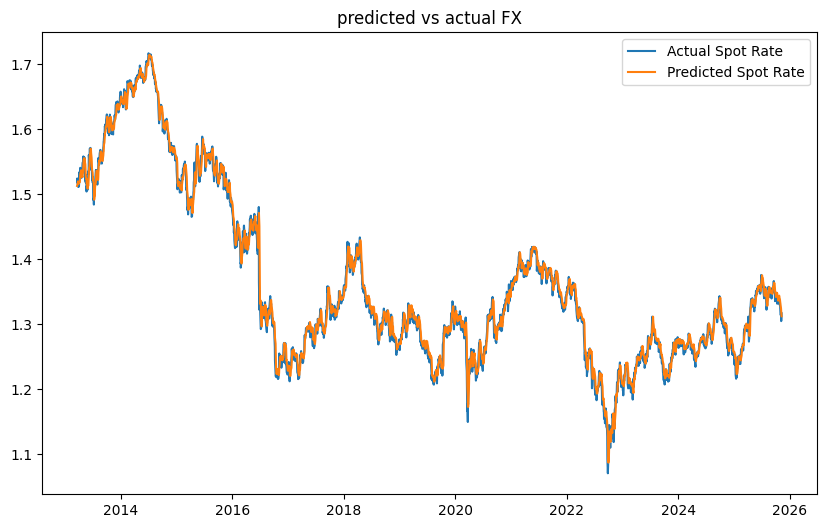

In [7]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


bilstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual FX")
plt.legend()
plt.show()

In [13]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}%')


# root mean squared error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean Squared Error: {rmse:.4f}')





print(np.round(bilstm_comparison_df,4).head(20))
print(np.round(bilstm_comparison_df,4).tail(20))


Mean Absolute Percentage Error: 0.0064
R2 Score: 99.24%
Root Mean Squared Error: 0.0117
            Date  Actual Spot Rate  Predicted Spot Rate
10596 2013-03-21            1.5180               1.5124
10597 2013-03-22            1.5239               1.5133
10598 2013-03-25            1.5184               1.5158
10599 2013-03-26            1.5156               1.5176
10600 2013-03-27            1.5112               1.5194
10601 2013-03-28            1.5184               1.5188
10602 2013-03-29            1.5193               1.5166
10603 2013-04-01            1.5232               1.5158
10604 2013-04-02            1.5113               1.5171
10605 2013-04-03            1.5140               1.5183
10606 2013-04-04            1.5198               1.5182
10607 2013-04-05            1.5336               1.5180
10608 2013-04-08            1.5257               1.5180
10609 2013-04-09            1.5317               1.5214
10610 2013-04-10            1.5315               1.5270
10611 2013-04-11